<a href="https://colab.research.google.com/github/claudiaxpreda/SII/blob/main/SII_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import gensim 
from gensim.models import Word2Vec
from tqdm import tqdm

import tensorflow as tf

from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Lambda, Flatten
from tensorflow.keras.models import Sequential, load_model, model_from_config
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [2]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download("punkt")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
# !wget http://nlp.stanford.edu/data/glove.6B.zip
# !unzip glove*.zip

In [4]:
WORKDIR = os.getcwd()
FILES_PATH = WORKDIR + '/drive/MyDrive/SII/SII-Challenge/'


In [5]:
DEV_NAME = 'referate-dev.json'
TRAIN_NAME = 'referate-train.json'
TEST_DEV = 'referate-test.json'

def get_frame(name):
  return pd.read_json(FILES_PATH + name)


In [6]:
train = get_frame(TRAIN_NAME)
dev = get_frame(DEV_NAME)
test = get_frame(TEST_DEV)

def print_size(name, frame):
  format = 'The size of {} set is: {}'
  print(format.format(name, len(frame)))

**Data Analyze**

In [7]:
print_size('train', train)
print_size('dev', dev)
print_size('test', test)

The size of train set is: 4725
The size of dev set is: 500
The size of test set is: 500


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4725 entries, 0 to 4724
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   index     4725 non-null   int64  
 1   filename  4725 non-null   object 
 2   text      4725 non-null   object 
 3   category  4725 non-null   object 
 4   grade     4725 non-null   float64
dtypes: float64(1), int64(1), object(3)
memory usage: 184.7+ KB


In [9]:
train.isnull().sum()

index       0
filename    0
text        0
category    0
grade       0
dtype: int64

In [10]:
train.head(5)

,index,filename,text,category,grade
0,3685,Referat Piercing-ul si adolescentii,Piercing-ul si tatuajele - vanitati adolescent...,psihologie,5.65
1,775,Gradinile Suspendate Ale Semiramidei,GRADINILE SUSPENDATE ALE SEMIRAMIDEI A doua mi...,istorie,9.00
2,1765,Referat Mihail Sadoveanu,MIHAIL SADOVEANU (1880-1961) \nMihail Sadovea...,romana,5.36
3,3691,Referat Eminescu,EMINESCU \nS-a nascut pe 15 ianuarie 1850 la ...,romana,5.35
4,3402,Moara,Moara cu noroc Ioan Slavici \nCaracterizarea l...,romana,10.00


In [11]:
train_categories = train.category.unique()
test_categories = test.category.unique()

print(train_categories)

['psihologie' 'istorie' 'romana' 'biologie' 'geografie']


In [12]:
no_text = train[train['text'].str.len() == 0]
no_text

,index,filename,text,category,grade
3635,5178,Dezvoltarea Rurala In Zona Valiug,,biologie,10.0
4000,4202,0ape Orase,,geografie,9.0


**Embeddings**

In [13]:
# sentences = train["text"].apply(lambda x: x.split()).values
# vocab = build_vocab(sentences)
# print()
# print({k: vocab[k] for k in list(vocab)[:5]})

In [14]:
train['processed_text'] = train['text'].apply(lambda x: x.lower())
train.head(5)

,index,filename,text,category,grade,processed_text
0,3685,Referat Piercing-ul si adolescentii,Piercing-ul si tatuajele - vanitati adolescent...,psihologie,5.65,piercing-ul si tatuajele - vanitati adolescent...
1,775,Gradinile Suspendate Ale Semiramidei,GRADINILE SUSPENDATE ALE SEMIRAMIDEI A doua mi...,istorie,9.00,gradinile suspendate ale semiramidei a doua mi...
2,1765,Referat Mihail Sadoveanu,MIHAIL SADOVEANU (1880-1961) \nMihail Sadovea...,romana,5.36,mihail sadoveanu (1880-1961) \nmihail sadovea...
3,3691,Referat Eminescu,EMINESCU \nS-a nascut pe 15 ianuarie 1850 la ...,romana,5.35,eminescu \ns-a nascut pe 15 ianuarie 1850 la ...
4,3402,Moara,Moara cu noroc Ioan Slavici \nCaracterizarea l...,romana,10.00,moara cu noroc ioan slavici \ncaracterizarea l...


In [15]:
# punct_mapping = {"‘": "'", "₹": "e", "´": "'", "°": "", "€": "e", "™": "tm", "√": " sqrt ", "×": "x", "²": "2", "—": "-", "–": "-", "’": "'", "_": "-", 
#                  "`": "'", '“': '"', '”': '"', '“': '"', "£": "e", '∞': 'infinity', 'θ': 'theta', '÷': '/', 'α': 'alpha', '•': '.', 'à': 'a', '−': '-', 
#                  'β': 'beta', '∅': '', '³': '3', 'π': 'pi', }

# punct = "/-'?!.,#$%\'()*+-/:;<=>@[\\]^_`{|}~" + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&'

# def clean_special_chars(text, punct, mapping):
#     for p in mapping:
#         text = text.replace(p, mapping[p])
    
#     for p in punct:
#         text = text.replace(p, f' {p} ')
    
#     specials = {'\u200b': ' ', '…': ' ... ', '\ufeff': '', 'करना': '', 'है': ''}  # Other special characters that I have to deal with in last
#     for s in specials:
#         text = text.replace(s, specials[s])
    
#     return text

# train['processed_text'] = train['processed_text'].apply(lambda x : clean_special_chars(x, punct, punct_mapping))
# train.head(5)

In [16]:
import re

def clean_numbers(x):

    x = re.sub('[0-9]{5,}', '#####', x)
    x = re.sub('[0-9]{4}', '####', x)
    x = re.sub('[0-9]{3}', '###', x)
    x = re.sub('[0-9]{2}', '##', x)
    x = re.sub('[0-9]', '#', x)

    return x

train['processed_text'] = train['processed_text'].apply(lambda x : clean_numbers(x))
train.head(5)

,index,filename,text,category,grade,processed_text
0,3685,Referat Piercing-ul si adolescentii,Piercing-ul si tatuajele - vanitati adolescent...,psihologie,5.65,piercing-ul si tatuajele - vanitati adolescent...
1,775,Gradinile Suspendate Ale Semiramidei,GRADINILE SUSPENDATE ALE SEMIRAMIDEI A doua mi...,istorie,9.00,gradinile suspendate ale semiramidei a doua mi...
2,1765,Referat Mihail Sadoveanu,MIHAIL SADOVEANU (1880-1961) \nMihail Sadovea...,romana,5.36,mihail sadoveanu (####-####) \nmihail sadovea...
3,3691,Referat Eminescu,EMINESCU \nS-a nascut pe 15 ianuarie 1850 la ...,romana,5.35,eminescu \ns-a nascut pe ## ianuarie #### la ...
4,3402,Moara,Moara cu noroc Ioan Slavici \nCaracterizarea l...,romana,10.00,moara cu noroc ioan slavici \ncaracterizarea l...


In [17]:
train['processed_text'] = train['processed_text'].apply(lambda x : re.sub(r'\s+$', '', x, flags=re.M))
train.head(5)

,index,filename,text,category,grade,processed_text
0,3685,Referat Piercing-ul si adolescentii,Piercing-ul si tatuajele - vanitati adolescent...,psihologie,5.65,piercing-ul si tatuajele - vanitati adolescent...
1,775,Gradinile Suspendate Ale Semiramidei,GRADINILE SUSPENDATE ALE SEMIRAMIDEI A doua mi...,istorie,9.00,gradinile suspendate ale semiramidei a doua mi...
2,1765,Referat Mihail Sadoveanu,MIHAIL SADOVEANU (1880-1961) \nMihail Sadovea...,romana,5.36,mihail sadoveanu (####-####)\nmihail sadovean...
3,3691,Referat Eminescu,EMINESCU \nS-a nascut pe 15 ianuarie 1850 la ...,romana,5.35,eminescu\ns-a nascut pe ## ianuarie #### la b...
4,3402,Moara,Moara cu noroc Ioan Slavici \nCaracterizarea l...,romana,10.00,moara cu noroc ioan slavici\ncaracterizarea lu...


In [18]:
train['processed_text'] = train['processed_text'].apply(lambda x : x.rstrip('\r\n\t').replace('\n', ' ').replace('\t', ' '))
train.head(5)

,index,filename,text,category,grade,processed_text
0,3685,Referat Piercing-ul si adolescentii,Piercing-ul si tatuajele - vanitati adolescent...,psihologie,5.65,piercing-ul si tatuajele - vanitati adolescent...
1,775,Gradinile Suspendate Ale Semiramidei,GRADINILE SUSPENDATE ALE SEMIRAMIDEI A doua mi...,istorie,9.00,gradinile suspendate ale semiramidei a doua mi...
2,1765,Referat Mihail Sadoveanu,MIHAIL SADOVEANU (1880-1961) \nMihail Sadovea...,romana,5.36,mihail sadoveanu (####-####) mihail sadoveanu...
3,3691,Referat Eminescu,EMINESCU \nS-a nascut pe 15 ianuarie 1850 la ...,romana,5.35,eminescu s-a nascut pe ## ianuarie #### la bo...
4,3402,Moara,Moara cu noroc Ioan Slavici \nCaracterizarea l...,romana,10.00,moara cu noroc ioan slavici caracterizarea lui...


In [19]:
train.processed_text.iloc[100]

'echipamentul de  baza           echipamentul esential era format  din coif (cassis), armura (lorica  segmentata), sabie cu # taisuri (gladius), sulita de lungime medie pt. aruncare  (pilium), scutul (scutum) si sandale.          coiful era era fabricat in general din bronz si incepand cu anul ### i.e.n. acoperea ceafa si fruntea.     armura se numea lorica segmentata , fiind  formata din mai multe lame din bronz suprapuse.  se purta de aseamenea si camasa de zale.          gladiusul era o sabie extrem de eficienta. era de dimensiuni mici (aprox ##cm), fiind astfel  mult mai usor de manuit decat una grea, necesitand si mai putina forta si energie.        piliumul  (sulita) purta un rol essential in   lupta. se compunea dintr-un varf ascutit de metal asezat pe un suport de lemn. sulita, lunga  de #m,  era aruncata spre adversar putand sa zdrobeasca scutul acestuia,  facandu-l mult mai vulnerabil in fata mortii.             apararea frontala a soldatului roman era oferita de scutum. aces

In [20]:
dev['processed_text'] = dev['text'].apply(lambda x: x.lower())
dev['processed_text'] = dev['processed_text'].apply(lambda x : clean_numbers(x))

dev['processed_text'] = dev['processed_text'].apply(lambda x : re.sub(r'\s+$', '', x, flags=re.M))
dev['processed_text'] = dev['processed_text'].apply(lambda x : x.rstrip('\r\n').replace('\n', ' ').replace('\t', ' '))


In [21]:
test['processed_text'] = test['text'].apply(lambda x: x.lower())
test['processed_text'] = test['processed_text'].apply(lambda x : clean_numbers(x))

test['processed_text'] = test['processed_text'].apply(lambda x : re.sub(r'\s+$', '', x, flags=re.M))
test['processed_text'] = test['processed_text'].apply(lambda x : x.rstrip('\r\n').replace('\n', ' ').replace('\t', ' '))


In [22]:
     

w2v_model = Word2Vec(min_count=20,
                     window=2,
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=1)

**Models**

12341.541587301588 24126.33832184855 577296


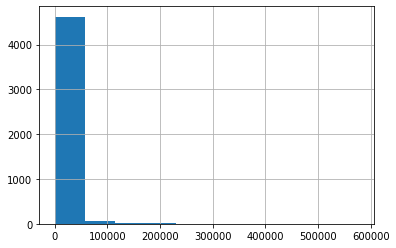

In [23]:
lens = train.text.str.len()
print(lens.mean(), lens.std(), lens.max())
lens.hist()

In [24]:

embed_size = 300 # how big is each word vector
max_features = 20000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 1000 # max number of words in a question to use


## Tokenize the sentences
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(train['processed_text']))
train_X = tokenizer.texts_to_sequences(train['processed_text'])
val_X = tokenizer.texts_to_sequences(train['processed_text'])
test_X = tokenizer.texts_to_sequences(test['processed_text'])

## Pad the sentences 
train_X = pad_sequences(train_X, maxlen=maxlen)
val_X = pad_sequences(val_X, maxlen=maxlen)
test_X = pad_sequences(test_X, maxlen=maxlen)

## Get the target values




In [25]:
Y_train = train['grade'].values
Y_val = dev['grade'].values

In [28]:
# max_features = 50000
# max_len = 30000
def get_model_1():
    model = Sequential()
    model.add(Embedding(max_features, embed_size))
    model.add(LSTM(128, dropout=0.4, recurrent_dropout=0.4, input_shape=[1, 300], return_sequences=True))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='relu'))
    return model

def compile_model(model):
  model.compile(loss=tf.keras.losses.MeanSquaredError(name="loss_mse")
, optimizer='rmsprop', metrics=tf.keras.losses.MeanSquaredError(name="mse"))

print(get_model_1().summary())



Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 300)         6000000   
_________________________________________________________________
lstm_4 (LSTM)                (None, None, 128)         219648    
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 128)         0         
_________________________________________________________________
dense_2 (Dense)              (None, None, 1)           129       
Total params: 6,219,777
Trainable params: 6,219,777
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:

model = get_model_1()
compile_model(model)
batch_size = 8
epochs = 2


early = EarlyStopping(monitor="val_loss_mse", mode="min", patience=5)


callbacks_list = [early]

with tf.device('/device:GPU:0'):
  history = model.fit(train_X, Y_train, validation_data=(val_X, Y_val), batch_size=batch_size, epochs=epochs, callbacks=callbacks_list)

Epoch 1/2
 71/591 [==>...........................] - ETA: 31:20 - loss: 11.7750 - mse: 11.7750

In [ ]:
model.save("/content/drive/MyDrive/SII/v1-no-embeddings.h5")


**Train**

**Results**

**Bert**